### Question1
- Linear regression

In [380]:
import numpy as np
from ct_support_code import *
data = np.load('ct_data.npz')
X_train = data['X_train']; X_val = data['X_val']; X_test = data['X_test']
y_train = data['y_train']; y_val = data['y_val']; y_test = data['y_test']

In [350]:
y_train.mean()

-9.13868774539957e-15

In [351]:
y_val_mean=y_val.mean()
std_error=np.std(y_val,ddof=1) / np.sqrt(np.size(y_val))
y_val_mean,std_error

(-0.2160085093241599, 0.01290449880016868)

In [352]:
y_train_5785=y_train[:5785]
std_error_ytrain=np.std(y_train_5785,ddof=1) / np.sqrt(np.size(y_train_5785))
std_error_ytrain

0.011927303389170828

In [381]:
xtrain_ind=[]
for i in range(X_train.shape[1]):
    n=0
    for j in range(X_train.shape[0]):
        if X_train[j,i]==X_train[0,i]:
            n+=1
    if n==X_train.shape[0]:
        xtrain_ind+=[i]

X_train1=np.delete(X_train,xtrain_ind,axis=1)
X_val1=np.delete(X_val,xtrain_ind,axis=1)
X_test1=np.delete(X_test,xtrain_ind,axis=1)

# find identical columns
_,indices= np.unique(X_train1,axis=1,return_index=True)
X_train=X_train1[:,np.sort(indices)]
X_val=X_val1[:,np.sort(indices)]
X_test=X_test1[:,np.sort(indices)]


xtrain_ind,set(list(range(X_train1.shape[1])))-set(list(indices))

([59, 69, 179, 189, 351], {76, 77, 185, 195, 283, 354})

### Question2
- Data preprocess

In [8]:
def fit_linreg(X, yy, alpha):
    N=X.shape[0]
    K=X.shape[1]
    XX=np.hstack(( np.vstack((X,np.sqrt(alpha)*np.identity(K))),np.vstack((np.ones(N)[:,None],np.zeros(K)[:,None]))))   
    y=np.vstack((yy[:,None],np.zeros(K)[:,None]))
    return np.linalg.lstsq(XX,y,rcond=None)[0]

In [9]:
w_linreg=fit_linreg(X_train, y_train, alpha=30)
w_gradopt,b_gradopt=fit_linreg_gradopt(X_train, y_train, alpha=30)

pred_train_lst=np.hstack((X_train,np.ones(X_train.shape[0])[:,None]))@w_linreg
pred_train_grad=np.hstack((X_train,np.ones(X_train.shape[0])[:,None]))@np.hstack((w_gradopt,b_gradopt))

pred_val_lst=np.hstack((X_val,np.ones(X_val.shape[0])[:,None]))@w_linreg
pred_val_grad=np.hstack((X_val,np.ones(X_val.shape[0])[:,None]))@np.hstack((w_gradopt,b_gradopt))

In [34]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [11]:
print(rmse(pred_train_lst,y_train[:,None]),rmse(pred_train_grad[:,None],y_train[:,None]))

0.3567565397204054 0.35675563654706866


In [12]:
print(rmse(pred_val_lst,y_val[:,None]),rmse(pred_val_grad[:,None],y_val[:,None]))

0.4230521968394692 0.4230558675897738


### Question3
- Cross validation

In [35]:
K = 20 
mx = np.max(y_train); mn = np.min(y_train); hh = (mx-mn)/(K+1)
thresholds = np.linspace(mn+hh, mx-hh, num=K, endpoint=True)

alpha=30
D= X_train.shape[1]
pred_train_logi=np.zeros((X_train.shape[0],K))
pred_val_logi=np.zeros((X_val.shape[0],K))
ww_q3_h=np.zeros((D,K))
bb_q3_h=np.zeros(K)
for kk in range(K):
    labels = y_train > thresholds[kk]
    args = (X_train, labels, alpha)    
    init= (np.zeros(D), np.array(0))
    ww, bb = minimize_list(logreg_cost, init, args)
    ww_q3_h[:,kk]=ww
    bb_q3_h[kk]=bb
    pred_train_logi[:,kk]=1/(1 + np.exp(-np.dot(X_train, ww) -bb))
    pred_val_logi[:,kk]=1/(1 + np.exp(-np.dot(X_val, ww) -bb))

w_linreg_q3=fit_linreg(pred_train_logi, y_train, alpha=30)
w_gradopt_q3,b_gradopt_q3=fit_linreg_gradopt(pred_train_logi, y_train, alpha=30)

pred_train_gradopt_q3=np.hstack((pred_train_logi,np.ones(pred_train_logi.shape[0])[:,None]))@np.hstack((w_gradopt_q3,b_gradopt_q3))
pred_val_gradopt_q3=np.hstack((pred_val_logi,np.ones(pred_val_logi.shape[0])[:,None]))@np.hstack((w_gradopt_q3,b_gradopt_q3))

print(rmse(pred_train_gradopt_q3[:,None],y_train[:,None]),rmse(pred_val_gradopt_q3[:,None],y_val[:,None]))

0.15441177075471604 0.25424891324609983


In [15]:
print(rmse(pred_train_lst_q3,y_train[:,None]),rmse(pred_train_gradopt_q3[:,None],y_train[:,None]))

0.15441150430070244 0.15441177075471604


In [16]:
print(rmse(pred_val_lst_q3,y_val[:,None]),rmse(pred_val_gradopt_q3[:,None],y_val[:,None]))

0.2542477297981976 0.25424891324609983


### Question4
- Neural network

In [55]:
D = X_train.shape[1]
alpha=30
args = (X_train, y_train, alpha)

# a sensible random initialisation of weight
ww4=0.1*np.random.randn(K)/np.sqrt(K) #(20,)
bb4=0.1*np.random.randn()/np.sqrt(K)
V4=0.1*np.random.randn(K,D)/np.sqrt(K) #(20,373)
bk4=0.1*np.random.randn(K)/np.sqrt(K) #(20,)

init_sensible =(ww4,bb4,V4,bk4)
para_fit_sensible= minimize_list(nn_cost, init_sensible,args)

pred_train_gradopt_sensible=nn_cost(para_fit_sensible, X_train)
pred_val_gradopt_sensible=nn_cost(para_fit_sensible, X_val)

rmse_train_sensible=rmse(pred_train_gradopt_sensible[:,None],y_train[:,None])
rmse_val_sensible=rmse(pred_val_gradopt_sensible[:,None],y_val[:,None])
print(rmse_train_sensible,rmse_val_sensible)

# initialised by the fitted weight in q3
init_from_q3 = (w_gradopt_q3,b_gradopt_q3,ww_q3_h.T,bb_q3_h)
para_fit_from_q3= minimize_list(nn_cost, init_from_q3, args)

pred_train_q4_from_q3=nn_cost(para_fit_from_q3, X_train)
pred_val_q4_from_q3=nn_cost(para_fit_from_q3, X_val)
rmse_train_from_q3=rmse(pred_train_q4_from_q3[:,None],y_train[:,None])
rmse_val_from_q3=rmse(pred_val_q4_from_q3[:,None],y_val[:,None])

print(rmse_train_from_q3,rmse_val_from_q3)

0.1411982558279669 0.2747922268495088
0.1396777862846726 0.2674357583329988


In [37]:
# initialised by the fitted weight in q3
init_from_q3 = (w_gradopt_q3,b_gradopt_q3,ww_q3_h.T,bb_q3_h)
para_fit_from_q3= minimize_list(nn_cost, init_from_q3, args)

pred_train_q4_from_q3=nn_cost(para_fit_from_q3, X_train)
pred_val_q4_from_q3=nn_cost(para_fit_from_q3, X_val)
rmse_train_from_q3=rmse(pred_train_q4_from_q3[:,None],y_train[:,None])
rmse_val_from_q3=rmse(pred_val_q4_from_q3[:,None],y_val[:,None])

print(rmse_train_from_q3,rmse_val_from_q3)

0.1396777862846726 0.2674357583329988


In [177]:
def train_nn_reg(alpha):
    D = X_train.shape[1]
    ww=0.1*np.random.randn(K)/np.sqrt(K)
    bb=0.1*np.random.randn()/np.sqrt(K)
    V=0.1*np.random.randn(K,D)/np.sqrt(K)
    bk=0.1*np.random.randn(K)/np.sqrt(K)
    init=(ww,bb,V,bk)
    args = (X_train, y_train, alpha)
    
    para_fit= minimize_list(nn_cost, init, args)
    pred_val=nn_cost(para_fit, X_val)
    pred_test=nn_cost(para_fit, X_test)
    
    return [rmse(pred_val[:,None],y_val[:,None]),rmse(pred_test[:,None],y_test[:,None])]

from scipy.stats import norm
alpha_set=np.arange(0, 50, 0.02)
alpha_ind=[500,1000,2000]
X_obs=alpha_set[alpha_ind]
X_rest=np.delete(alpha_set, alpha_ind)
validation_error=[train_nn_reg(x)[0] for x in X_obs]
test_error=[train_nn_reg(x)[1] for x in X_obs]

def alpha_opt(X_obs,X_rest):
    lmse_obs=[np.log(train_nn_reg(a)[0]) for a in X_obs]
    y_q5=[np.log(rmse_val_sensible)-lmse for lmse in lmse_obs]
    rest_cond_mu, rest_cond_cov=gp_post_par(X_rest, np.array(X_obs), np.array(y_q5))
    y_max=np.max(y_q5)
    
    PI=np.zeros(X_rest.shape[0])
    for i in range(X_rest.shape[0]):
        PI[i]=norm.cdf((rest_cond_mu[i]-y_max)/np.sqrt(rest_cond_cov[i,i]))

    a_opt_ind=int(np.where(PI==np.max(PI))[0])
    a_opt=X_rest[a_opt_ind]
    
    return a_opt_ind,a_opt

for i in range(5):
    a_opt_ind,a_opt=alpha_opt(X_obs,X_rest)
    alpha_ind=np.append(alpha_ind,a_opt_ind)
    X_obs=list(alpha_set[alpha_ind])
    X_rest=np.delete(alpha_set, alpha_ind)
    validation_error+=[train_nn_reg(a_opt)[0]]
    test_error+=[train_nn_reg(a_opt)[1]]
    

# find the optimal alpha and corresponding validation RMSE
optimal_index=int(np.where(validation_error==np.min(validation_error))[0])
optimal_index=int(np.where(validation_error==np.min(validation_error))[0])
print('optimal alpha: {0}\nvalidation RMSE: {1}\ntest RMSE: {2}'.format(X_obs[optimal_index],
                                                                        validation_error[optimal_index],
                                                                       test_error[optimal_index]))

optimal alpha: 5.26
validation RMSE: 0.2458645527230757
test RMSE: 0.2894986905790171


In [171]:
Alpha = np.arange(0, 50, 0.02)
obs_id = [500, 1000, 2000]
obs_lc = Alpha[obs_id]
rest_lc = np.delete(Alpha,obs_id)
obs_rmse = []
obs_y = []
bsl = np.log(rmse_val_sensible)
for alpha in obs_lc:
    rmse_new = train_nn_reg(alpha)[0]
    obs_rmse.append(rmse_new)
    y = bsl - np.log(rmse_new)
    obs_y.append(y)
obs_y = np.array(obs_y)
gp_post_mu, gp_post_cov = gp_post_par(rest_lc, obs_lc, obs_y, sigma_y=0.01, ell=5.0, sigma_f=0.01)

In [172]:
print(obs_lc)
print(obs_y)

[10. 20. 40.]
[ 0.07906763  0.02873025 -0.04883634]


In [173]:
from scipy.stats import norm
def p_ipv(alpha_id):
    gp_post_mean = gp_post_mu[alpha_id]
    gp_post_sd = np.sqrt(gp_post_cov[alpha_id][alpha_id])
    z = (gp_post_mean - np.max(obs_y))/gp_post_sd
    phi = norm.cdf(z)
    return phi    

In [174]:
for i in range(5):
    p_ipv_max = 0
    id_alpha_max = 0
    for alpha_id in range(len(rest_lc)):
        p_ipv_alpha = p_ipv(alpha_id)
        if p_ipv_alpha > p_ipv_max:
            p_ipv_max = p_ipv_alpha
            id_alpha_max = alpha_id
            
    alpha_new = rest_lc[id_alpha_max]
    obs_lc = np.append(obs_lc,alpha_new)
    rest_lc = np.delete(rest_lc,id_alpha_max)
    rmse_new = train_nn_reg(alpha_new)[0]
    obs_rmse.append(rmse_new)
    y = bsl - np.log(rmse_new)
    obs_y = np.append(obs_y,y)
    gp_post_mu, gp_post_cov = gp_post_par(rest_lc, obs_lc, obs_y, sigma_y=0.01, ell=5.0, sigma_f=0.01)

In [175]:
print(obs_lc)
print(obs_y)
print(obs_rmse)

[10.   20.   40.   11.88  5.5   3.66  3.68  1.3 ]
[ 0.07906763  0.02873025 -0.04883634  0.00068048  0.15665171  0.12009522
  0.0910576   0.14746173]
[0.2539018174028048, 0.26700971074046476, 0.28854516113604883, 0.2746053006634157, 0.23494784624429949, 0.2436956349378917, 0.2508757179812092, 0.23711696460044912]


In [176]:
print(np.max(obs_y))
print(obs_lc[np.argmax(obs_y)])
print(obs_rmse[np.argmax(obs_y)])

0.15665171473574513
5.5
0.23494784624429949


In [65]:
def nn_cost_dropout(params, X, yy=None, alpha=None):
    """NN_COST simple neural network cost function and gradients, or predictions

           E, params_bar = nn_cost([ww, bb, V, bk], X, yy, alpha)
                    pred = nn_cost([ww, bb, V, bk], X)

     Cost function E can be minimized with minimize_list

     Inputs:
             params (ww, bb, V, bk), where:
                    --------------------------------
                        ww K,  hidden-output weights
                        bb     scalar output bias
                         V K,D hidden-input weights
                        bk K,  hidden biases
                    --------------------------------
                  X N,D input design matrix
                 yy N,  regression targets
              alpha     scalar regularization for weights

     Outputs:
                     E  sum of squares error
            params_bar  gradients wrt params, same format as params
     OR
               pred N,  predictions if only params and X are given as inputs
    """
    # Unpack parameters from list
    ww, bb, V, bk = params
    inclu_prob=0.9
    mask=np.random.binomial(1,inclu_prob,X.shape[1])
    X1=mask*X

    # Forwards computation of cost
    
    if yy is None:
        A = np.dot(X, V.T) + bk[None,:] # N,K
        P = 1 / (1 + np.exp(-A)) # N,K
        F = np.dot(P, ww) + bb # N,
        # user wants prediction rather than training signal:
        return F
    
    A = np.dot(X1, V.T) + bk[None,:] # N,K
    P = 1 / (1 + np.exp(-A)) # N,K
    F = np.dot(P, ww) + bb # N,
    res = F - yy # N,
    E = np.dot(res, res) + alpha*(np.sum(V*V) + np.dot(ww,ww)) # 1x1

    # Reverse computation of gradients
    F_bar = 2*res # N,
    ww_bar = np.dot(P.T, F_bar) + 2*alpha*ww # K,
    bb_bar = np.sum(F_bar) # scalar
    P_bar = np.dot(F_bar[:,None], ww[None,:]) # N,
    A_bar = P_bar * P * (1 - P) # N,
    V_bar = np.dot(A_bar.T, X1) + 2*alpha*V # K,    
    bk_bar = np.sum(A_bar, 0)
    

    return E, (ww_bar, bb_bar, V_bar, bk_bar)

In [68]:
D = X_train.shape[1]
alpha=30
args = (X_train, y_train, alpha)

# a sensible random initialisation of weight
ww41=0.1*np.random.randn(K)/np.sqrt(K) #(20,)
bb41=0.1*np.random.randn()/np.sqrt(K)
V41=0.1*np.random.randn(K,D)/np.sqrt(K) #(20,373)
bk41=0.1*np.random.randn(K)/np.sqrt(K) #(20,)


init_sensible1 =(ww41,bb41,V41,bk41)
para_fit_sensible1= minimize_list(nn_cost_dropout, init_sensible1,args)

pred_train_gradopt_sensible1=nn_cost_dropout(para_fit_sensible1, X_train)
pred_val_gradopt_sensible1=nn_cost_dropout(para_fit_sensible1, X_val)

rmse_train_sensible1=rmse(pred_train_gradopt_sensible1[:,None],y_train[:,None])
rmse_val_sensible1=rmse(pred_val_gradopt_sensible1[:,None],y_val[:,None])
print(rmse_train_sensible1,rmse_val_sensible1)


0.3924502530728152 0.40238956701862477


In [67]:
args1 = (X_train, y_train, 30)
para_fit_from_q31= minimize_list(nn_cost_dropout, init_from_q3, args1)
pred_train_q4_from_q31=nn_cost_dropout(para_fit_from_q31, X_train)
pred_val_q4_from_q31=nn_cost_dropout(para_fit_from_q31, X_val)

rmse_train_from_q31=rmse(pred_train_q4_from_q31[:,None],y_train[:,None])
rmse_val_from_q31=rmse(pred_val_q4_from_q31[:,None],y_val[:,None])

print(rmse_train_from_q31,rmse_val_from_q31)

0.1547928404390425 0.25542801743051763


In [289]:
def train_nn_reg_K(K,alpha):
    D = X_train.shape[1]
    
    args = (X_train, y_train, alpha)

    # a sensible random initialisation of weight
    ww=0.1*np.random.randn(K)/np.sqrt(K) #(K,)
    bb=0.1*np.random.randn()/np.sqrt(K)
    V=0.1*np.random.randn(K,D)/np.sqrt(K) #(K,373)
    bk=0.1*np.random.randn(K)/np.sqrt(K) #(K,)


    init_sensible =(ww,bb,V,bk)
    para_fit_sensible= minimize_list(nn_cost, init_sensible,args)

    pred_train_gradopt_sensible=nn_cost(para_fit_sensible, X_train)
    pred_val_gradopt_sensible=nn_cost(para_fit_sensible, X_val)
    pred_test_gradopt_sensible=nn_cost(para_fit_sensible, X_test)
    
    rmse_train_sensible=rmse(pred_train_gradopt_sensible[:,None],y_train[:,None])
    rmse_val_sensible=rmse(pred_val_gradopt_sensible[:,None],y_val[:,None])
    rmse_test_sensible=rmse(pred_test_gradopt_sensible[:,None],y_test[:,None])
    
    return(rmse_train_sensible,rmse_val_sensible,rmse_test_sensible)




K=np.arange(10, 25, 1)
error=np.zeros((K.shape[0],3))
for i,k in enumerate(K):
    error[i,0],error[i,1],error[i,2]=train_nn_reg_K(k,5.26)

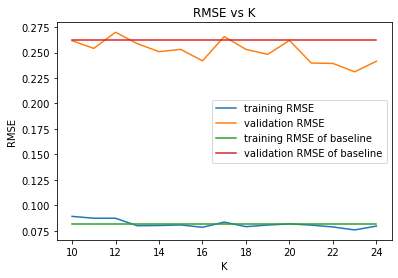

In [292]:
import matplotlib.pyplot as plt
baseline_ind=int(np.where(K==20)[0])

plt.plot(K,error[:,0],label='training RMSE')
plt.plot(K,error[:,1],label='validation RMSE')
plt.plot(np.linspace(np.min(K),np.max(K),2),np.ones(2)*error[baseline_ind,0],label='training RMSE of baseline' )
plt.plot(np.linspace(np.min(K),np.max(K),2),np.ones(2)*error[baseline_ind,1],label='validation RMSE of baseline')
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('RMSE vs K')
plt.legend()
plt.show()

In [196]:
np.mean(X_train)
np.std(X_train)

0.34139302588574966

### Question5
- Model improvement

In [332]:
def Normalization_data(data):
    for i in range(data.shape[0]):        
        data[i,:]=(data[i,:]-np.min(data[i,:]))/(np.max(data[i,:])-np.min(data[i,:]))
    return data

X_train1=Normalization_data(X_train)
X_val1=Normalization_data(X_val)

def train_nn_reg1(alpha,K,xtrain,xval,ytrain,yval):
    D = xtrain.shape[1]
    ww=0.1*np.random.randn(K)/np.sqrt(K)
    bb=0.1*np.random.randn()/np.sqrt(K)
    V=0.1*np.random.randn(K,D)/np.sqrt(K)
    bk=0.1*np.random.randn(K)/np.sqrt(K)
    init=(ww,bb,V,bk)
    args = (xtrain, ytrain, alpha)
    para_fit= minimize_list(nn_cost, init, args)
    pred_train=nn_cost(para_fit,xtrain)
    pred_val=nn_cost(para_fit, xval)
    return [rmse(pred_train[:,None],ytrain[:,None]),rmse(pred_val[:,None],yval[:,None])]

In [334]:
X_train.shape[1],X_val.shape[1]

(373, 373)

In [335]:
X_train1=np.zeros((X_train.shape))
X_val1=np.zeros((X_val.shape))
for i in range(X_train.shape[1]):        
    X_train1[:,i]=(X_train[:,i]-np.min(X_train[:,i]))/(np.max(X_train[:,i])-np.min(X_train[:,i]))
    #X_val1[:,i]=(X_val1[:,i]-np.min(X_train[:,i]))/(np.max(X_train[:,i])-np.min(X_train[:,i]))
    X_val1[:,i]=(X_val1[:,i]-np.min(X_train[:,i]))/(np.max(X_train[:,i])-np.min(X_train[:,i]))

In [389]:
X_train1=(X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_val1=(X_val-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
rmse_q6=[None]*10
for i in range(10):
    rmse_q6[i]=train_nn_reg1(alpha=5.26,K=20,xtrain=X_train1,xval=X_val1,y_train=y_train)

In [391]:
rmse_q6

[[0.04671449437028345, 0.25694686173212483],
 [0.04663000688662072, 0.254195603903346],
 [0.04622616691922857, 0.22777664527073258],
 [0.046132999950808946, 0.2421681500260043],
 [0.046380252622138664, 0.24884384738916718],
 [0.04854355380320544, 0.25172635953305506],
 [0.04815784934469329, 0.24448185263683483],
 [0.04662090430421377, 0.25373012897371844],
 [0.049947770083964185, 0.2403880454879269],
 [0.0476000474567066, 0.25165950052956587]]

In [396]:
X_train1=(X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_val1=(X_val-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
rmse_q6_alpha30=[None]*10
for i in range(10):
    rmse_q6_alpha30[i]=train_nn_reg1(alpha=30,K=20,xtrain=X_train1,xval=X_val1,y_train=y_train)

In [397]:
rmse_q6_alpha30

[[0.0786865671457154, 0.24894906511115186],
 [0.07623406063068447, 0.2288295752826641],
 [0.0747300221739672, 0.24186156722955204],
 [0.07634340603858514, 0.23032988532027424],
 [0.07867952254695026, 0.23767555573789903],
 [0.0765909574641889, 0.23703921167629122],
 [0.07505294527178667, 0.2366808954232176],
 [0.07881010469278509, 0.2347180341634777],
 [0.07586248283291565, 0.2237525842031976],
 [0.07733038969357928, 0.23504194465713793]]

In [412]:
def train_nn_reg1(alpha,K,xtrain,xval):
    D = xtrain.shape[1]
    ww=0.1*np.random.randn(K)/np.sqrt(K)
    bb=0.1*np.random.randn()/np.sqrt(K)
    V=0.1*np.random.randn(K,D)/np.sqrt(K)
    bk=0.1*np.random.randn(K)/np.sqrt(K)
    init=(ww,bb,V,bk)
    args = (xtrain, y_train, alpha)
    para_fit= minimize_list(nn_cost, init, args)
    pred_train=nn_cost(para_fit,xtrain)
    pred_val=nn_cost(para_fit, xval)
   
    return [rmse(pred_train[:,None],y_train[:,None]),rmse(pred_val[:,None],y_val[:,None])]

X_train1=(X_train-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_val1=(X_val-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
X_test1=(X_test-np.mean(X_train,axis=0))/np.std(X_train,axis=0)
print(train_nn_reg1(alpha=30,K=20,xtrain=X_train1,xval=X_val1))

[0.07585786662030743, 0.23347711261242346]


In [401]:
def train_nn_reg2(alpha):
    K=20
    D = X_train1.shape[1]
    ww=0.1*np.random.randn(K)/np.sqrt(K)
    bb=0.1*np.random.randn()/np.sqrt(K)
    V=0.1*np.random.randn(K,D)/np.sqrt(K)
    bk=0.1*np.random.randn(K)/np.sqrt(K)
    init=(ww,bb,V,bk)
    args = (X_train1, y_train, alpha)
    
    para_fit= minimize_list(nn_cost, init, args)
    pred_val=nn_cost(para_fit, X_val1)
    pred_test=nn_cost(para_fit, X_test1)
    
    return [rmse(pred_val[:,None],y_val[:,None]),rmse(pred_test[:,None],y_test[:,None])]

from scipy.stats import norm
alpha_set=np.arange(0, 50, 0.02)
alpha_ind=[500,1000,2000]
X_obs=alpha_set[alpha_ind]
X_rest=np.delete(alpha_set, alpha_ind)
validation_error=[train_nn_reg2(x)[0] for x in X_obs]
test_error=[train_nn_reg2(x)[1] for x in X_obs]

def alpha_opt(X_obs,X_rest):
    lmse_obs=[np.log(train_nn_reg2(a)[0]) for a in X_obs]
    y_q5=[np.log(rmse_val_sensible)-lmse for lmse in lmse_obs]
    rest_cond_mu, rest_cond_cov=gp_post_par(X_rest, np.array(X_obs), np.array(y_q5))
    y_max=np.max(y_q5)
    
    PI=np.zeros(X_rest.shape[0])
    for i in range(X_rest.shape[0]):
        PI[i]=norm.cdf((rest_cond_mu[i]-y_max)/np.sqrt(rest_cond_cov[i,i]))

    a_opt_ind=int(np.where(PI==np.max(PI))[0])
    a_opt=X_rest[a_opt_ind]
    
    return a_opt_ind,a_opt

for i in range(5):
    a_opt_ind,a_opt=alpha_opt(X_obs,X_rest)
    alpha_ind=np.append(alpha_ind,a_opt_ind)
    X_obs=list(alpha_set[alpha_ind])
    X_rest=np.delete(alpha_set, alpha_ind)
    validation_error+=[train_nn_reg2(a_opt)[0]]
    test_error+=[train_nn_reg2(a_opt)[1]]
    

# find the optimal alpha and corresponding validation RMSE
optimal_index=int(np.where(validation_error==np.min(validation_error))[0])
optimal_index=int(np.where(validation_error==np.min(validation_error))[0])
print('optimal alpha: {0}\nvalidation RMSE: {1}\ntest RMSE: {2}'.format(X_obs[optimal_index],
                                                                        validation_error[optimal_index],
                                                                       test_error[optimal_index]))

In [402]:
for i in range(5):
    a_opt_ind,a_opt=alpha_opt(X_obs,X_rest)
    alpha_ind=np.append(alpha_ind,a_opt_ind)
    X_obs=list(alpha_set[alpha_ind])
    X_rest=np.delete(alpha_set, alpha_ind)
    validation_error+=[train_nn_reg2(a_opt)[0]]
    test_error+=[train_nn_reg2(a_opt)[1]]
    

# find the optimal alpha and corresponding validation RMSE
optimal_index=int(np.where(validation_error==np.min(validation_error))[0])
optimal_index=int(np.where(validation_error==np.min(validation_error))[0])
print('optimal alpha: {0}\nvalidation RMSE: {1}\ntest RMSE: {2}'.format(X_obs[optimal_index],
                                                                        validation_error[optimal_index],
                                                                       test_error[optimal_index]))

optimal alpha: 13.56
validation RMSE: 0.22584492846350543
test RMSE: 0.26916665509975735


In [403]:
train_nn_reg1(alpha=13.56,K=25,xtrain=X_train1,xval=X_val1,y_train=y_train)

[0.06319133951755751, 0.24529008209952305]

In [405]:
np.min(y_train)

-1.8679386519531087

In [ ]:
a_opt_ind=int(np.where(PI==np.max(PI))[0])
a_opt=X_rest[a_opt_ind]

In [355]:
X_val.shape

(5785, 373)

In [324]:
nn_cost(para_fit, X_val1)

array([nan, nan, nan, ..., nan, nan, nan])